In [1]:
#import important Library
!pip install --quiet statsmodels mplfinance shap

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import shap

sns.set(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12,6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


In [5]:
#Load and Read Dataset
merged_path = "/content/merged_sentiment_trades.csv"
fg_path     = "/content/merged_sentiment_trades.csv"
tr_path     = "/content/merged_sentiment_trades.csv"

# choose which to load:
if os.path.exists(merged_path):
    df = pd.read_csv(merged_path)
    print("Loaded merged file:", merged_path)
else:
    print("Merged file not found, will attempt to load separate files.")
    fg = pd.read_csv(fg_path)       # sentiment
    tr = pd.read_csv(tr_path)       # historical trades
    print("Loaded fg and tr")
    # basic merge attempt on 'date' if present in both
    if 'date' in fg.columns and 'date' in tr.columns:
        df = tr.merge(fg, on='date', how='left')
        print("Merged on 'date'")
    else:
        # fallback: keep separate
        df = None


Loaded merged file: /content/merged_sentiment_trades.csv


In [19]:
#check dataype
if df is None:
    print("No merged df. Show separate previews:")
    display(fg.head())
    display(tr.head())
else:
    display(df.head())
    print(df.shape)
    print(df.columns)
    display(df.info())
    display(df.describe(include='all').T)


,date,total_trades,buy_trades,sell_trades,total_volume_usd,avg_execution_price,daily_pnl,total_fees,net_buy_pressure,sentiment_value,sentiment_class,date_utc
0,2023-03-28,3,3,0,4.770000e+02,1898.133333,0.000000e+00,0.000000,3,59.0,Greed,2023-03-28
1,2023-11-14,1045,491,554,1.155543e+07,10454.871036,1.555034e+02,2794.570654,-63,69.0,Greed,2023-11-14
2,2024-03-09,6962,3371,3591,3.940677e+07,9771.897315,1.769655e+05,6812.781233,-220,84.0,Extreme Greed,2024-03-09
3,2024-07-03,7141,3505,3636,2.184323e+07,2663.132338,1.587424e+05,8743.877486,-131,50.0,Neutral,2024-07-03
4,2024-10-27,35241,14927,20314,1.039478e+08,5367.503277,3.189461e+06,21539.462735,-5387,74.0,Greed,2024-10-27


(7, 12)
Index(['date', 'total_trades', 'buy_trades', 'sell_trades', 'total_volume_usd',
       'avg_execution_price', 'daily_pnl', 'total_fees', 'net_buy_pressure',
       'sentiment_value', 'sentiment_class', 'date_utc'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 7 non-null      datetime64[ns]
 1   total_trades         7 non-null      int64         
 2   buy_trades           7 non-null      int64         
 3   sell_trades          7 non-null      int64         
 4   total_volume_usd     7 non-null      float64       
 5   avg_execution_price  7 non-null      float64       
 6   daily_pnl            7 non-null      float64       
 7   total_fees           7 non-null      float64       
 8   net_buy_pressure     7 non-null      int64         
 9   sentiment_value      7

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,7,NaN,NaN,NaN,2024-06-16 06:51:25.714285824,2023-03-28 00:00:00,2024-01-11 00:00:00,2024-07-03 00:00:00,2024-12-23 12:00:00,2025-06-15 00:00:00,NaN
total_trades,7.0,NaN,NaN,NaN,30174.857143,3.0,4003.5,7141.0,31101.0,133871.0,47639.566148
buy_trades,7.0,NaN,NaN,NaN,14670.857143,3.0,1931.0,3505.0,14622.5,66081.0,23493.865954
sell_trades,7.0,NaN,NaN,NaN,15504.0,0.0,2072.5,3636.0,16478.5,67790.0,24192.949131
total_volume_usd,7.0,NaN,NaN,NaN,170169634.637143,477.0,16699332.055,39406770.25,207111519.06,704158492.98,258964181.137956
avg_execution_price,7.0,NaN,NaN,NaN,9272.808622,1898.133333,4015.317807,9771.897315,10778.464507,23652.065078,7360.713241
daily_pnl,7.0,NaN,NaN,NaN,1470994.134777,0.0,35932.425495,158742.378078,1683213.261896,6699925.190574,2581231.979915
total_fees,7.0,NaN,NaN,NaN,35122.531509,0.0,4803.675944,8743.877486,41244.223787,145018.043618,52764.403487
net_buy_pressure,7.0,NaN,NaN,NaN,-833.142857,-5387.0,-964.5,-131.0,-30.0,1675.0,2234.454626
sentiment_value,7.0,NaN,NaN,NaN,60.571429,44.0,47.0,59.0,71.5,84.0,15.618975


In [7]:
# Parse dates & standardize


def parse_datetime_column(df):
    # try to detect date-like columns
    for c in df.columns:
        if c.lower() in ['date','timestamp','ts','time','date_utc','datetime','timestamp_ist']:
            try:
                df[c+'_parsed'] = pd.to_datetime(df[c], errors='coerce')
            except:
                df[c+'_parsed'] = pd.to_datetime(df[c], unit='s', errors='coerce')
    return df

if df is not None:
    # if merged has explicit 'date', prefer that
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.sort_values('date').reset_index(drop=True)
        df['date_utc'] = df['date'].dt.tz_localize('Asia/Kolkata', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC') \
                         if (df['date'].dt.tz is None and df['date'].dt.tz is not None) else df['date']
        # If above fails, we keep naive datetimes but ensure consistent dtype
        df['date_utc'] = pd.to_datetime(df['date'], errors='coerce')
    else:
        df = parse_datetime_column(df)
else:
    fg['date'] = pd.to_datetime(fg.get('date', fg.get('timestamp')), errors='coerce')
    tr['date'] = pd.to_datetime(tr.get('date', tr.get('Timestamp IST')), errors='coerce')
    fg = fg.sort_values('date').reset_index(drop=True)
    tr = tr.sort_values('date').reset_index(drop=True)
    df = tr.merge(fg, on='date', how='left')
    df['date_utc'] = pd.to_datetime(df['date'], errors='coerce')

print("After parsing, sample rows:")
display(df.head())


After parsing, sample rows:


,date,total_trades,buy_trades,sell_trades,total_volume_usd,avg_execution_price,daily_pnl,total_fees,net_buy_pressure,value,classification,date_utc
0,2023-03-28,3,3,0,4.770000e+02,1898.133333,0.000000e+00,0.000000,3,59.0,Greed,2023-03-28
1,2023-11-14,1045,491,554,1.155543e+07,10454.871036,1.555034e+02,2794.570654,-63,69.0,Greed,2023-11-14
2,2024-03-09,6962,3371,3591,3.940677e+07,9771.897315,1.769655e+05,6812.781233,-220,84.0,Extreme Greed,2024-03-09
3,2024-07-03,7141,3505,3636,2.184323e+07,2663.132338,1.587424e+05,8743.877486,-131,50.0,Neutral,2024-07-03
4,2024-10-27,35241,14927,20314,1.039478e+08,5367.503277,3.189461e+06,21539.462735,-5387,74.0,Greed,2024-10-27


In [8]:

# attempt gentle renaming:
col_map = {}
for c in df.columns:
    lc = c.lower()
    if 'total_trades' in lc or 'total trades' in lc or 'total_trades'==lc:
        col_map[c] = 'total_trades'
    if 'buy_trades' in lc or 'buy trades' in lc:
        col_map[c] = 'buy_trades'
    if 'sell_trades' in lc or 'sell trades' in lc:
        col_map[c] = 'sell_trades'
    if 'total_volume' in lc or 'total_volume_usd' in lc or 'volume'==lc:
        col_map[c] = 'total_volume_usd'
    if 'avg_execution_price' in lc or 'execution price' in lc:
        col_map[c] = 'avg_execution_price'
    if 'daily_pnl' in lc or 'pnl'==lc:
        col_map[c] = 'daily_pnl'
    if lc in ['value','sentiment','fear_greed_value','fg_value']:
        col_map[c] = 'sentiment_value'
    if 'classification' in lc or 'sentiment' in lc and 'class' in lc:
        col_map[c] = 'sentiment_class'

df = df.rename(columns=col_map)
print("Renamed cols mapping:", col_map)
print("Columns now:", df.columns.tolist())


Renamed cols mapping: {'total_trades': 'total_trades', 'buy_trades': 'buy_trades', 'sell_trades': 'sell_trades', 'total_volume_usd': 'total_volume_usd', 'avg_execution_price': 'avg_execution_price', 'daily_pnl': 'daily_pnl', 'value': 'sentiment_value', 'classification': 'sentiment_class'}
Columns now: ['date', 'total_trades', 'buy_trades', 'sell_trades', 'total_volume_usd', 'avg_execution_price', 'daily_pnl', 'total_fees', 'net_buy_pressure', 'sentiment_value', 'sentiment_class', 'date_utc']


In [9]:
# Missing values & simple imputation ===
print("Missing counts:")
display(df[['date', 'total_trades','buy_trades','sell_trades','total_volume_usd','avg_execution_price','daily_pnl','sentiment_value','sentiment_class']].isna().sum())

# For time-series, forward-fill sentiment where small gaps exist:
if 'sentiment_value' in df.columns:
    df['sentiment_value'] = df['sentiment_value'].ffill().bfill()

# numeric columns to numeric
numeric_cols = ['total_trades','buy_trades','sell_trades','total_volume_usd','avg_execution_price','daily_pnl','sentiment_value']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with date missing:
df = df[df['date'].notna()].reset_index(drop=True)
print("After cleaning, shape:", df.shape)


Missing counts:


,0
date,0
total_trades,0
buy_trades,0
sell_trades,0
total_volume_usd,0
avg_execution_price,0
daily_pnl,0
sentiment_value,1
sentiment_class,1


After cleaning, shape: (7, 12)


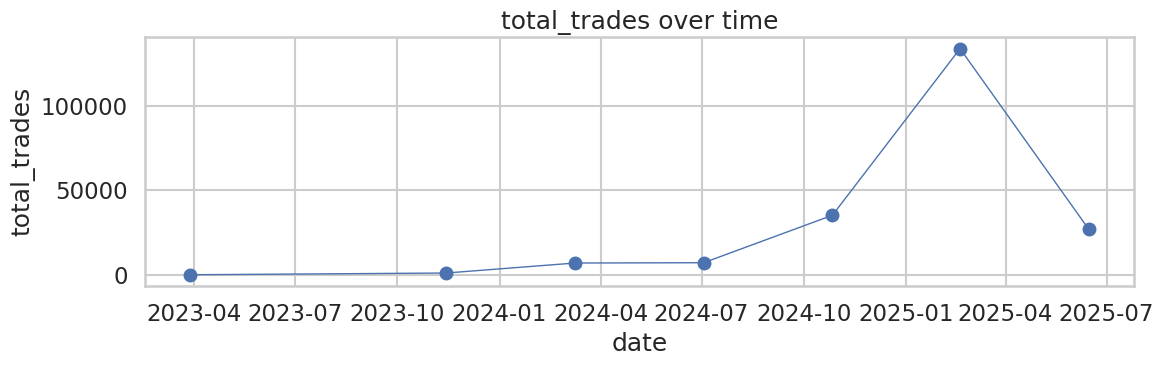

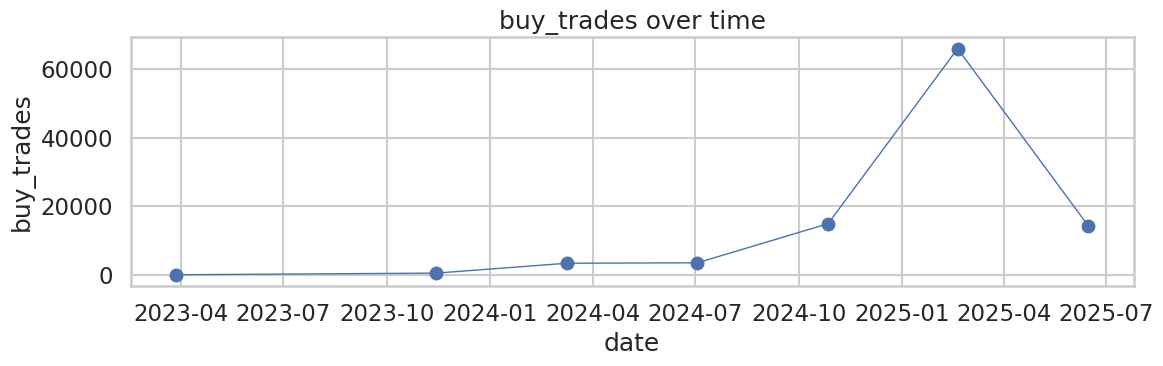

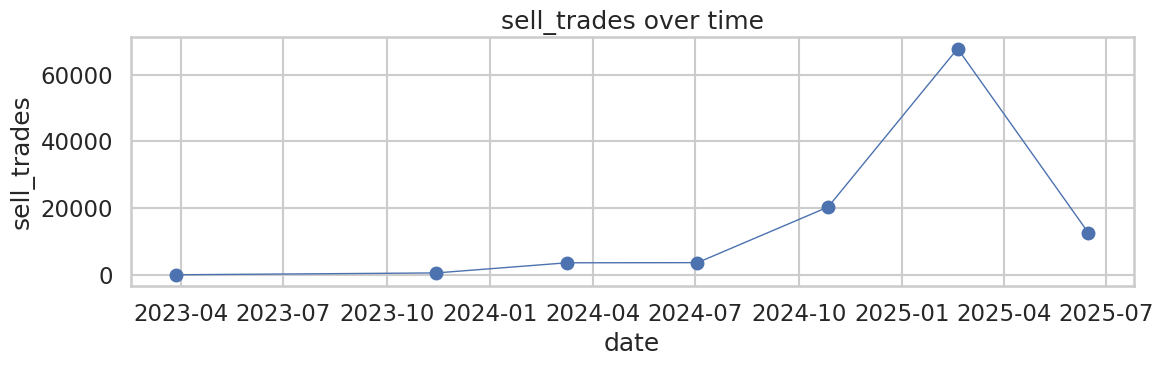

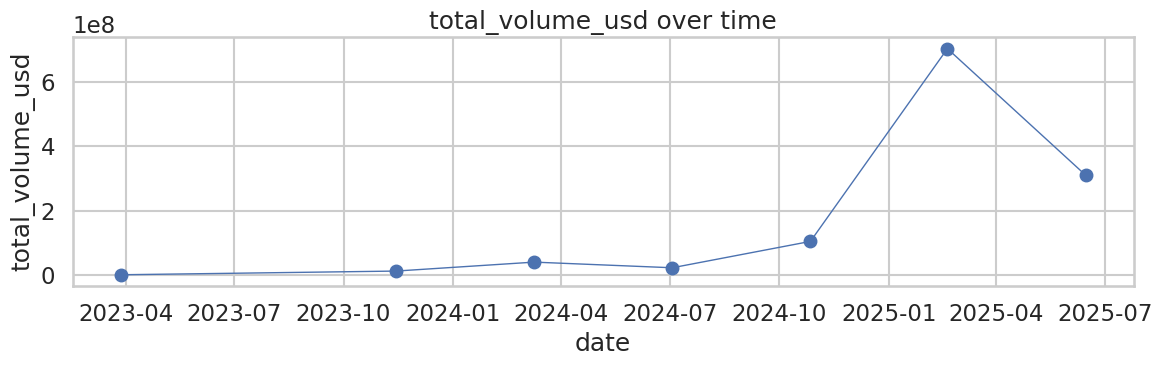

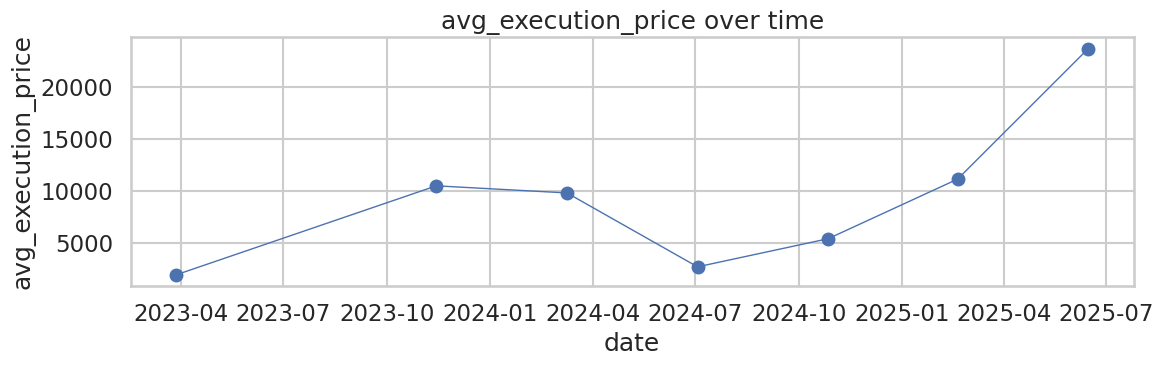

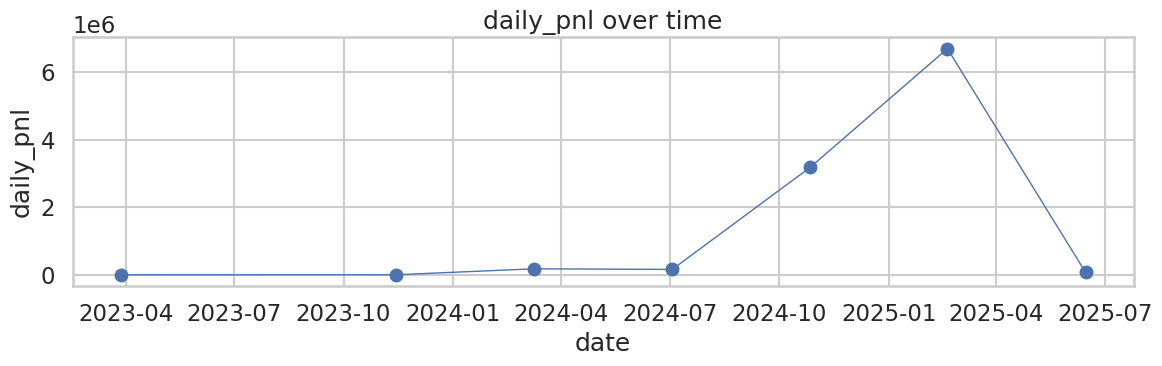

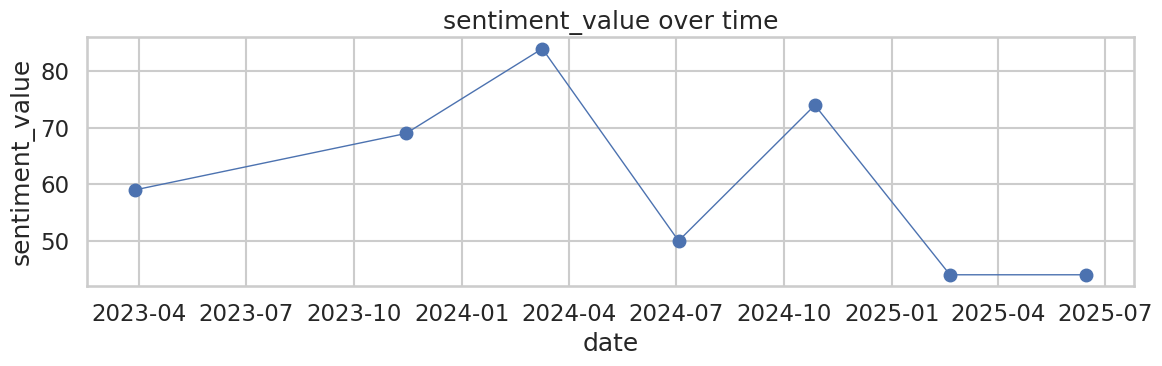

In [10]:
#  Basic plots - time series of key metrics
plot_cols = [c for c in ['total_trades','buy_trades','sell_trades','total_volume_usd','avg_execution_price','daily_pnl','sentiment_value'] if c in df.columns]
for c in plot_cols:
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df[c], marker='o', linewidth=1)
    plt.title(c + " over time")
    plt.xlabel("date"); plt.ylabel(c)
    plt.tight_layout()
    plt.show()


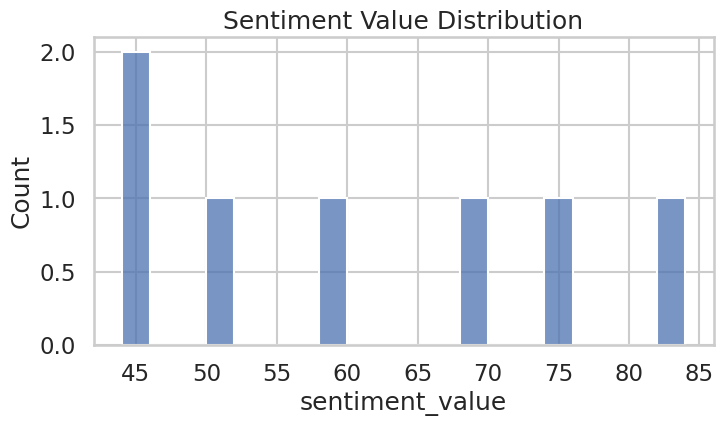

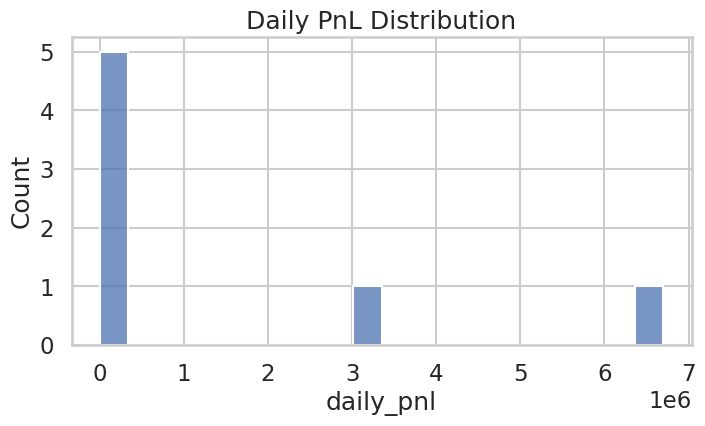

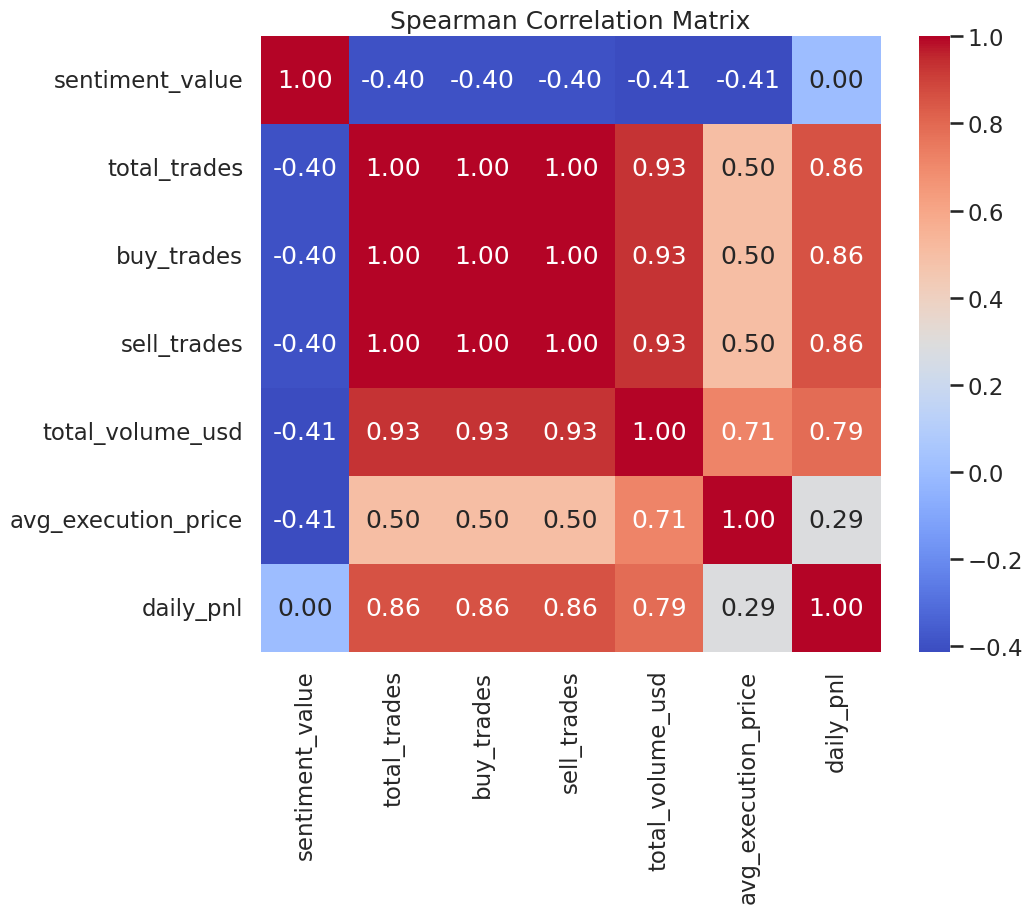

In [11]:
#  Distribution & correlation heatmap
# Distribution of sentiment and daily_pnl
if 'sentiment_value' in df.columns:
    plt.figure(figsize=(8,4)); sns.histplot(df['sentiment_value'].dropna(), bins=20); plt.title('Sentiment Value Distribution'); plt.show()
if 'daily_pnl' in df.columns:
    plt.figure(figsize=(8,4)); sns.histplot(df['daily_pnl'].dropna(), bins=20); plt.title('Daily PnL Distribution'); plt.show()

# correlation matrix
corr_cols = [c for c in ['sentiment_value','total_trades','buy_trades','sell_trades','total_volume_usd','avg_execution_price','daily_pnl'] if c in df.columns]
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()


Lag vs Spearman corr (sentiment shifted forward):
   lag  spearman_corr
0    0      -0.396412
1    1      -0.028571
2    2       0.000000
3    3       0.800000
4    4      -0.500000
5    5      -1.000000
6    6            NaN
7    7            NaN


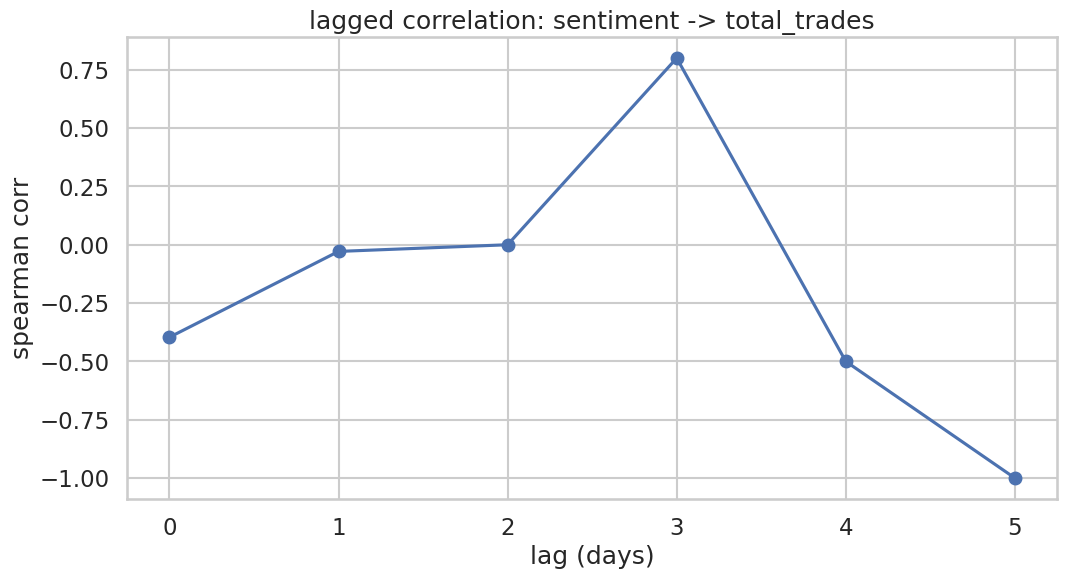

In [12]:
#Lagged correlations (sentiment leading trading metrics) ===
# compute correlation between sentiment(t - lag) and trade_count(t) for lags 0..7 (days) or hours if daily data
max_lag = 7
results = []
if 'sentiment_value' in df.columns and 'total_trades' in df.columns:
    for lag in range(0, max_lag+1):
        corr = df['sentiment_value'].shift(lag).corr(df['total_trades'], method='spearman')
        results.append((lag, corr))
    print("Lag vs Spearman corr (sentiment shifted forward):")
    print(pd.DataFrame(results, columns=['lag','spearman_corr']))
    # plot
    lags, corrs = zip(*results)
    plt.plot(lags, corrs, marker='o'); plt.xlabel('lag (days)'); plt.ylabel('spearman corr'); plt.title('lagged correlation: sentiment -> total_trades'); plt.grid(True); plt.show()
else:
    print("Required columns missing for lagged correlation.")


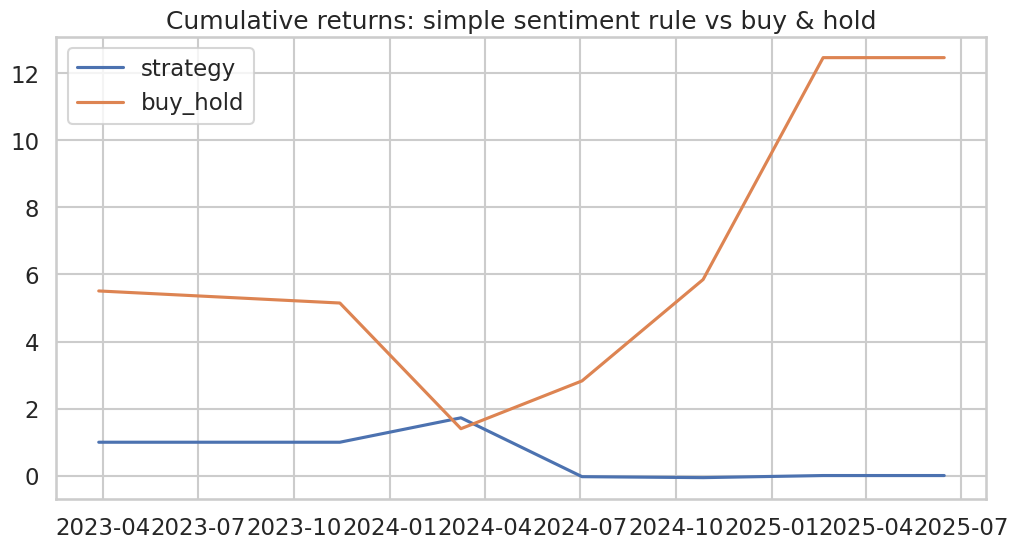

Strategy total return: 0.007216103553308715
Mean daily return: -0.05834206337138326 std: 0.8898648909114295 Sharpe approx: -1.0407777106271814


In [17]:
# Simple backtest of a rule-based signal using sentiment
# Example rule: if sentiment drops by >= delta in last 1 day -> buy next day; if rises by >= delta -> sell next day.
if 'sentiment_value' in df.columns and 'avg_execution_price' in df.columns:
    data = df.set_index('date').sort_index().copy()
    data['sent_delta_1d'] = data['sentiment_value'] - data['sentiment_value'].shift(1)
    delta = 10  # threshold; tune
    # generate positions: +1 long, -1 short, 0 flat executed at next day's avg_execution_price
    data['signal'] = 0
    data.loc[data['sent_delta_1d'] <= -delta, 'signal'] = 1
    data.loc[data['sent_delta_1d'] >= delta, 'signal'] = -1
    # shift signal to simulate execution next day at open (use avg_execution_price as proxy)
    data['signal_exec'] = data['signal'].shift(1).fillna(0)
    # forward return for next day (price_t+1 / price_t - 1)
    data['price_ret_1d'] = data['avg_execution_price'].pct_change().shift(-1)  # next day return
    data['strategy_ret'] = data['signal_exec'] * data['price_ret_1d']
    data['cum_strat'] = (1 + data['strategy_ret'].fillna(0)).cumprod()
    data['cum_buy_hold'] = (1 + data['price_ret_1d'].fillna(0)).cumprod()

    plt.plot(data.index, data['cum_strat'], label='strategy')
    plt.plot(data.index, data['cum_buy_hold'], label='buy_hold')
    plt.legend(); plt.title('Cumulative returns: simple sentiment rule vs buy & hold'); plt.show()

    # basic metrics:
    strat_ret = data['strategy_ret'].dropna()
    print("Strategy total return:", data['cum_strat'].iloc[-1])
    print("Mean daily return:", strat_ret.mean(), "std:", strat_ret.std(), "Sharpe approx:", (strat_ret.mean()/strat_ret.std()) * np.sqrt(252))
else:
    print("Need sentiment_value and avg_execution_price for backtest.")


In [20]:
df

,date,total_trades,buy_trades,sell_trades,total_volume_usd,avg_execution_price,daily_pnl,total_fees,net_buy_pressure,sentiment_value,sentiment_class,date_utc
0,2023-03-28,3,3,0,4.770000e+02,1898.133333,0.000000e+00,0.000000,3,59.0,Greed,2023-03-28
1,2023-11-14,1045,491,554,1.155543e+07,10454.871036,1.555034e+02,2794.570654,-63,69.0,Greed,2023-11-14
2,2024-03-09,6962,3371,3591,3.940677e+07,9771.897315,1.769655e+05,6812.781233,-220,84.0,Extreme Greed,2024-03-09
3,2024-07-03,7141,3505,3636,2.184323e+07,2663.132338,1.587424e+05,8743.877486,-131,50.0,Neutral,2024-07-03
4,2024-10-27,35241,14927,20314,1.039478e+08,5367.503277,3.189461e+06,21539.462735,-5387,74.0,Greed,2024-10-27
5,2025-02-19,133871,66081,67790,7.041585e+08,11102.057978,6.699925e+06,145018.043618,-1709,44.0,Fear,2025-02-19
6,2025-06-15,26961,14318,12643,3.102753e+08,23652.065078,7.170935e+04,60948.984840,1675,44.0,NaN,2025-06-15
